In [1]:
%matplotlib widget
import numpy as np
import json, copy
import os, math, glob
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from IPython.display import clear_output, display
from ipyfilechooser import FileChooser

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *

from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Fluence scans
* [Reduce one run](#Reduce_one)
* [Plot averaged curves](#Ave_data)
* [Overlay different scans](#Overlay)

<a id='Reduce_one'></a>
## Reduce one run

In [6]:
pgroup='p22588'
runnumber = 195
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0195


'/sf/alvra/data/p22588/raw/run0195-PtLQ_horLaser_1ps_2469/meta/scan.json'

In [11]:
quantile_corr = 0.8

detector_XAS = channel_diode_2
detector_Izero = channel_Izero122

reducedir='/sf/alvra/data/{}/work/Reduced_data/'.format(pgroup)
saveflag = True
#######################################################################################################
from sfdata import SFScanInfo
#try:
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)
xlabel = scan.parameters['name'][0]
xunits = scan.parameters['units'][0]

(DataDiode_pump, DataDiode_unpump, Pump_probe_Diode, Izero_pump, Izero_unpump, correlation, readbacks, goodshots) = \
XAS_scanPP_1diode_noTT(scan, detector_XAS, detector_Izero, quantile_corr)

if saveflag:
    os.makedirs(reducedir+run_name, exist_ok=True)
    save_reduced_data_1diode(reducedir, run_name, scan, 
                             DataDiode_pump, DataDiode_unpump, Pump_probe_Diode, goodshots, correlation)
    # save_data_XANES(reducedir, run_name, waveplate, 
    #             DataDiode_pump, DataDiode_unpump, Pump_probe_Diode, goodshots)
data, _ = load_reduced_data(pgroup, reducedir, [runnumber])
globals().update(data)
#except:
#    print ('==> json file not yet ready!! <==')

Processing: run0195-PtLQ_horLaser_1ps_2469
Step 21 of 21: Processing acq0021

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet      501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH2_VAL_GET 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY    501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 247 pump and 247 unpump shots
151 shots out of 247 survived
Step 21 of 21: Processed acq0021
correlation Diode (all shots) = 0.9969694719036993
------------------------------
Processed 21 out of 21 files


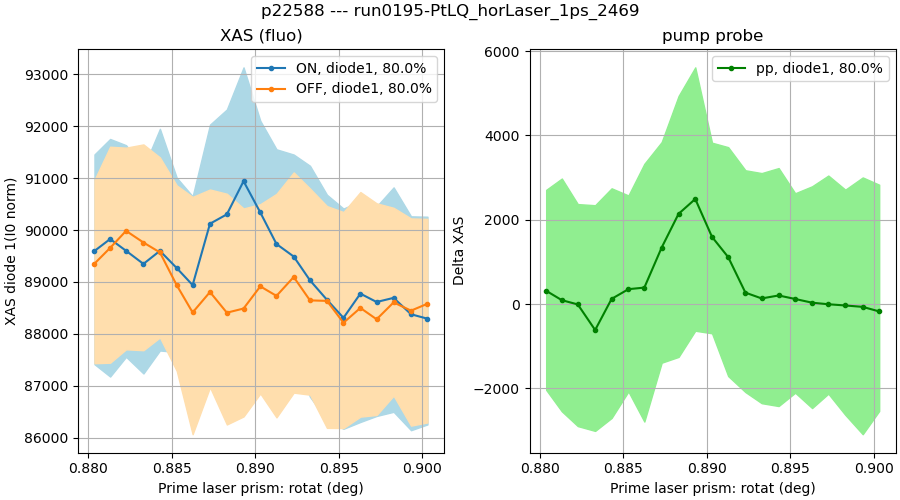

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(titlestring, fontsize = 12)
readbacks = readbacks[0]

XAS_pump = DataDiode_pump[:,0]
err_low_pump = DataDiode_pump[:,1]
err_high_pump = DataDiode_pump[:,2]
XAS_unpump = DataDiode_unpump[:,0]
err_low_unpump = DataDiode_unpump[:,1]
err_high_unpump = DataDiode_unpump[:,2]
XAS_pump_probe = Pump_probe_Diode[:,0]
err_low_pump_probe = Pump_probe_Diode[:,1]
err_high_pump_probe = Pump_probe_Diode[:,2]

ax1.plot(readbacks, XAS_pump, label='ON, diode1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(readbacks, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(readbacks, XAS_unpump, label='OFF, diode1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(readbacks, err_low_unpump, err_high_unpump, color='navajowhite')

ax1.set_xlabel('{} ({})'.format(xlabel, xunits))
#ax1.set_xlabel("Fluence (mJ/cm2)")
ax1.set_ylabel ("XAS diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(readbacks, XAS_pump_probe, label='pp, diode1, {}%'.format(quantile_corr*100),marker='.', color = 'g')
ax2.fill_between(readbacks, err_low_pump_probe, err_high_pump_probe, color='lightgreen')
#ax2.axes.errorbar(intensity, XAS_pump_probe, (XAS_pump_probe-err_low_pump_probe), (err_high_pump_probe-XAS_pump_probe), 
            # lw=1,color='green', markersize=0,capsize=3,capthick=1,
            #      ecolor='green',elinewidth=1)

#ax2.set_xscale('log')
        
ax2.set_xlabel('{} ({})'.format(xlabel, xunits))
#ax2.set_xlabel("Fluence (mJ/cm2)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

In [41]:
#[2.40744133e+02 1.67279498e-01 4.07745686e+01]
#waveplate2 = 0.12612736 + 66.03399024*(np.cos(np.pi/180.*(waveplate - 60.29428308)))**2

#[2.40744133e+02 1.67279498e-01 4.07745686e+01]
#waveplate2 = 0.167279498 + 40.7745686*(np.cos(np.pi/180.*(waveplate - 240.744133)))**2    ##calibration from 3.12 in the night
#waveplate2 = 0 + 44.82*(np.cos(np.pi/180.*(waveplate - 277.63)))**2    ##calibration from 3.12 in the night

#yscale = 8.16083889
#xshift = 91.2282651 

params = [8.884032634033035e-08, -4.7302965552968094e-05, 0.00972551379176431, -0.9228802318052738, 34.45745687645803]  # 470 nm
params = [5.900349650349897e-08, -3.483119658119821e-05, 0.007863167249417576, -0.8133037101787356, 33.00922843822912]  # 600 nm

p = np.poly1d(params)
print(np.shape(p))
#intensity = waveplate 
intensity = p(readbacks)                                                          ## pulse energy (in uJ)
#intensity = p(1) + p(2)*(2*np.cos(np.pi/180.*(waveplate + p(0))))**2                       ## pulse energy (in uJ)
#intensity = yscale*(2*np.cos(np.pi/180.*(waveplate - xshift)))**2
#intensity = (p2 + p3*(np.cos(2*np.pi/180.*(waveplate - p1)))**2 )*1e-3/(2.45*1e-5)   ## fluence (in mJ/cm2)

(5,)


# Plot Fluence scan

NameError: name 'intensity' is not defined

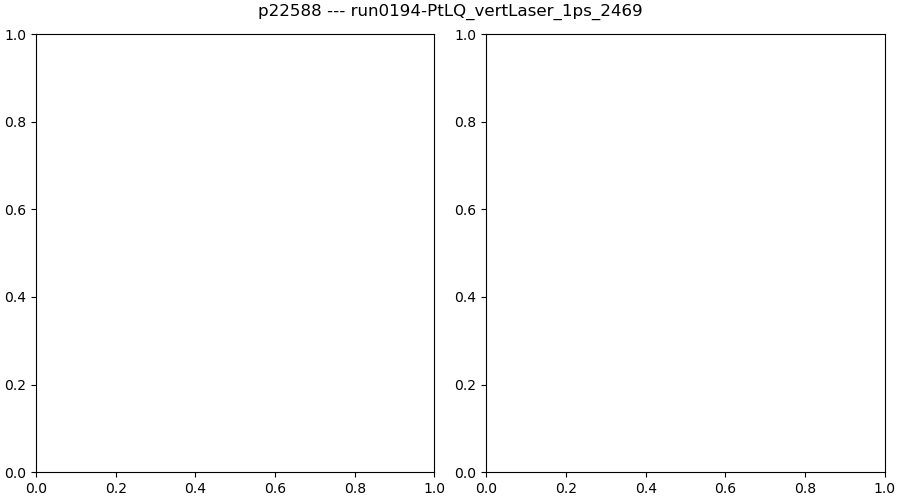

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(titlestring, fontsize = 12)

XAS_pump = DataDiode_pump[:,0]
err_low_pump = DataDiode_pump[:,1]
err_high_pump = DataDiode_pump[:,2]
XAS_unpump = DataDiode_unpump[:,0]
err_low_unpump = DataDiode_unpump[:,1]
err_high_unpump = DataDiode_unpump[:,2]
XAS_pump_probe = Pump_probe_Diode[:,0]
err_low_pump_probe = Pump_probe_Diode[:,1]
err_high_pump_probe = Pump_probe_Diode[:,2]

ax1.plot(intensity, XAS_pump, label='ON, diode1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(intensity, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(intensity, XAS_unpump, label='OFF, diode1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(intensity, err_low_unpump, err_high_unpump, color='navajowhite')

ax1.set_xlabel("Pulse energy (uJ)")
#ax1.set_xlabel("Fluence (mJ/cm2)")
ax1.set_ylabel ("XAS diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(intensity, XAS_pump_probe, label='pp, diode1, {}%'.format(quantile_corr*100),marker='.', color = 'g')
ax2.fill_between(intensity, err_low_pump_probe, err_high_pump_probe, color='lightgreen')
#ax2.axes.errorbar(intensity, XAS_pump_probe, (XAS_pump_probe-err_low_pump_probe), (err_high_pump_probe-XAS_pump_probe), 
            # lw=1,color='green', markersize=0,capsize=3,capthick=1,
            #      ecolor='green',elinewidth=1)

#ax2.set_xscale('log')
        
ax2.set_xlabel("Pulse energy (uJ)")
#ax2.set_xlabel("Fluence (mJ/cm2)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

<a id='Ave_data'></a>
## Average scans 1 diode

In [ ]:
pgroup = 'p21210'
Loaddir_name = 'Reduced_fluencescan_test'

#runlist = np.arange(22, 23)
runlist = [300]
##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
try:
    print ('{} scan(s) of {} steps each'.format(len(runlist), int(len(DataDiode1_pump)/len(runlist))))
except:
    print ('Not all the runs have the same number of steps')

In [ ]:
#params = [-6.26456878e-02, 5.40802255e+01, -1.74193710e+04, 2.47921762e+06, -1.31421048e+08]
p = np.poly1d(params)
intensity = p(readbacks)       

In [ ]:
#### CH1 ####
DataDiode1_pump   = np.asarray(DataDiode1_pump)
DataDiode1_unpump = np.asarray(DataDiode1_unpump)
Pump_probe_Diode1 = np.asarray(Pump_probe_Diode1)
goodshots1        = np.asarray(goodshots1)

DataDiode1_pump   = np.reshape(np.asarray(DataDiode1_pump), (len(runlist), -1, 3))
DataDiode1_unpump = np.reshape(np.asarray(DataDiode1_unpump), (len(runlist), -1, 3))
Pump_probe_Diode1 = np.reshape(np.asarray(Pump_probe_Diode1), (len(runlist), -1, 3))
goodshots1        = np.reshape(np.asarray(goodshots1), (len(runlist), -1))

XAS1_pump        = np.mean(DataDiode1_pump[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump[:,:,0]-DataDiode1_pump[:,:,1])/np.sqrt(goodshots1), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump[:,:,2]-DataDiode1_pump[:,:,0])/np.sqrt(goodshots1), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump[:,:,0]-DataDiode1_unpump[:,:,1])/np.sqrt(goodshots1), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump[:,:,2]-DataDiode1_unpump[:,:,0])/np.sqrt(goodshots1), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe_Diode1[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

In [ ]:
quantile_corr = 0.5

fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(10, 6), constrained_layout=True)
plt.suptitle(titlestring_stack)

#ff = glob.glob(Loaddir+'/*{:04d}*/XANES_energy_eV.npy'.format(runlist[0]))
#waveplate = np.load(ff[0])
intensity = p(waveplate) 

ax1.fill_between(intensity, XAS1_pump - err1_low_pump, XAS1_pump + err1_high_pump , label='diode 1 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
ax1.fill_between(intensity, XAS1_unpump - err1_low_unpump, XAS1_unpump + err1_high_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
ax2.fill_between(intensity, XAS1_pump_probe - err1_low_pump_probe, XAS1_pump_probe + err1_low_pump_probe, label='pump probe 1, {}%'.format(quantile_corr*100),color='limegreen')
ax2.plot(intensity, XAS1_pump_probe, color='green', marker='.')

ax1.set_xlabel("Pulse Energy")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.set_xlabel("Pulse Energy")
ax2.set_ylabel ("DeltaXAS Diode 1")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

<a id='Overlay'></a>
## Overlay different scans

In [63]:
#runlist = np.arange(283, 293, 1)
runlist = [61, 223]
Loaddir = '../Reduced_fluencescan/'

##############################################
import glob
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 2 runs: [61, 223] from ../Reduced_fluencescan/


['../Reduced_fluencescan/run0061-Fluence_scan_1ps_2145p8eV/run_array.npy',
 '../Reduced_fluencescan/run0223-fluence_scan_8982p1_1ps/run_array.npy']

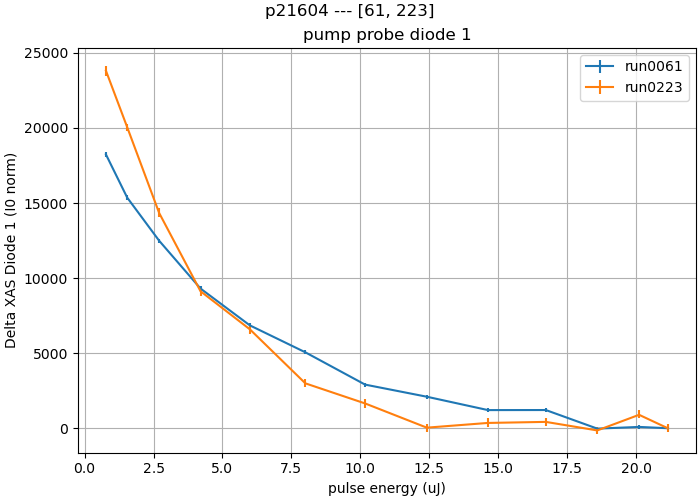

In [65]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)

keys = []

for run in runlist:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        waveplate = run_array[key]["readbacks"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
    
        #params = [-6.26456878e-02, 5.40802255e+01, -1.74193710e+04, 2.47921762e+06, -1.31421048e+08]
        p = np.poly1d(params)
        intensity = p(waveplate)
        
        ax1.axes.errorbar(intensity, XAS1_pump_probe[:,0]-XAS1_pump_probe[-1,0], (err1_low_pump_probe, err1_high_pump_probe), label=runnumber)
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("pulse energy (uJ)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

ax1.set_title('pump probe diode 1')

plt.show()

# Calculate laser fluence 

In [ ]:
fluences = 0.20514 +346.78 * (np.cos(np.pi/180*(Waveplate_deg-768.56)))**2

In [ ]:
print(Waveplate_deg)
print(fluences)
plt.figure()
plt.title(fc.selected.split('/')[-1])
plt.plot(fluences, XAS_pump_probe/XAS_unpump, marker = '.')
plt.grid()
plt.xlabel('Fluence (uJ)')
plt.ylabel('pump probe (%)')
plt.show()